In [1]:
from gurobipy import *

## 本研究

In [2]:
def IPS6(ship_num,stack_num,height,n,size,beta):
  O1=[i+1 for i in range(ship_num)]
  S=[i+1 for i in range(stack_num)]
  H=[i+1 for i in range(height)]
  P=[i+1 for i in range(ship_num)]
  f=stack_num*height-sum(n)

  from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
  import random
  from random import seed
  import numpy as np
  from scipy.stats import multivariate_normal

  # 期待値と分散共分散行列の準備
  a=np.arange(1,2*ship_num,0.4)
  a=list(a)
  a=random.sample(a,ship_num)
  mean=np.sort(a)
  cov=np.zeros((ship_num,ship_num))
  for i in range(ship_num):
      for j in range(ship_num):
          if i==j:
              cov[i][i]=2*abs(np.random.randn())
  for i in range(ship_num):
      for j in range(ship_num):
          if i!=j:
              cov[i][j]=(-0.75)**abs(i-j)

  data_1 = np.random.multivariate_normal(mean, cov, size=size)

  O_=np.argsort(data_1)
  O_=O_+np.ones((size,ship_num)).astype(int)
  O=O_.tolist()
  # a=[]
  # b={}
  # for i in O:
  #   # print(i)
  #   if not i in a:
  #     a.append(i)
  #     for j in a:
  #       b[tuple(j)]=O.count(j)

  m=Model("IPS6")

  alpha=m.addVar(vtype="C")

  # 変数の定義
  x,c,d={},{},{}
  for s in S:
    for h in H:
      for p in P:
        x[s,h,p]=m.addVar(vtype="B")

  for s in S:
    for h in range(2,len(H)+1):
      for i,o in enumerate(O):
        c[s,h,i]=m.addVar(vtype="c",lb=0)

  for i in range(len(O)):
    d[i]=m.addVar(vtype="C",lb=0)

  for p in P:
    m.addConstr(quicksum(x[s,h,p] for s in S for h in H)==n[p-1])

  for s in S:
    for h in H:
      m.addConstr(quicksum(x[s,h,p] for p in P)<=1)

  for s in S:
    for h in range(1,len(H)):
      m.addConstr(quicksum(x[s,h+1,p] for p in P)<=quicksum(x[s,h,p] for p in P))

  for s in S:
    for h in range(2,len(H)+1):
      for h_ in range(1,h):
        for i,o in enumerate(O):
          for j,p in enumerate(o):
            m.addConstr(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))

  for i in range(len(O)):
    m.addConstr(d[i]>=quicksum(c[s,h,i] for s in S for h in H if h!=1)-alpha)


  m.setObjective(alpha+quicksum(d[i] for i in range(len(O)))/((1-beta)*len(O)))

  if f>=height:
    m.optimize()
  else:
    print("f<h")

  print("================================================")

# def result(self):
  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:
  # for (s,h,p,t) in x:
  #   if t==len(T):
  #     if x[s,h,p,t].X>EPS:
  #       print("x[%2s,%2s,%2s,%2s]=%3s" %(s,h,p,t,x[s,h,p,t].X)

    for (s,h,i) in c:
      if c[s,h,i].X>EPS:
        print("c[%2s,%2s,%2s]=%3s  %4s" %(s,h,i,c[s,h,i].X,O[i]))

    global result
    result=np.zeros((height,stack_num))
    for (s,h,p) in x:
      if x[s,h,p].X>EPS:
    # print("x[%2s,%2s,%2s]=%3s  %4s" %(s,h,p,x[s,h,p].X,O[i]))
        result[height-h][s-1]=int(p)

    result=result.astype(int)
    print("VaR=",alpha.X)
    print("the objective function", m.objVal)
    print(result)


    data_2 = np.random.multivariate_normal(mean, cov, size=size)

    global OR
    OR_=np.argsort(data_2)
    OR_=OR_+np.ones((size,ship_num)).astype(int)
    OR=OR_.tolist()

    global penalty
    penalty=[]
    for k in OR:
      O=k
      a=0
      for j in range(stack_num):
          for i in range(1,height):
              for i_ in range(i+1,height+1):
                  if result[i-1][j]!=0 and result[i_-1][j]!=0:
                      if O.index(result[i-1][j])>O.index(result[i_-1][j]):
                          print(j+1,height-i+1,O)
                          a+=1
                          # print("penalty!")
                              # print(i,i_,j+1,O)
                          break
      penalty.append(a)
      # print(a)
    penalty=np.sort(penalty)
    penalty=penalty[round(0.95*size):]
    # penalty=penalty[round(0.8*size):]
    # print(penalty)

In [3]:
inst=[[5,5,[3,2,2,2,1,2,2,2,1,3]],[6,4,[3,2,2,2,1,2,2,2,1,3]],[4,4,[2,3,3,1,3]]]
pcvar=[]
for i in inst:
  ship_num=len(i[2])
  size=1000
  IPS6(ship_num,i[0],i[1],i[2],size,0.7)
  pcvar+=list(penalty)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-30
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 501055 rows, 21251 columns and 6022900 nonzeros
Model fingerprint: 0x0e584c29
Variable types: 21001 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 0 rows and 0 columns (presolve time = 8s) ...
Presolve removed 0 rows and 0 columns (presolve time = 11s) ...
Presolve removed 0 rows and 0 columns (presolve time = 15s) ...
Presolve removed 0 rows and 0 columns (presolve time = 20s) ...
Presolve removed 4320 rows and 0 columns (presolve time = 26s) ...
Presolve removed 4320 rows and 0 columns (presolve time = 30s) ...
Presolve removed 4320 rows and 0 columns (presolve time = 36s) ...
Pre

C:\Users\daiki\AppData\Local\Temp\ipykernel_18476\2180331667.py:29: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = np.random.multivariate_normal(mean, cov, size=size)


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 361052 rows, 19241 columns and 4340840 nonzeros
Model fingerprint: 0xa6d9d8a7
Variable types: 19001 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 1152 rows and 0 columns (presolve time = 10s) ...
Presolve removed 1152 rows and 0 columns (presolve time = 16s) ...
Presolve removed 1152 rows and 0 columns (presolve time = 20s) ...
Presolve removed 1152 rows and 0 columns (presolve time = 25s) ...
Presolve removed 290278 rows and 15238 columns (presolve time = 30s) ...
Presolve removed 290278 rows and 15238 columns
Presolve time: 33.72s
Presolved: 70774 rows, 4003 columns, 857136 nonzeros
Variable types: 3763 con

C:\Users\daiki\AppData\Local\Temp\ipykernel_18476\2180331667.py:119: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size)


1 1 [2, 6, 1, 4, 3, 5, 8, 7, 9, 10]
1 1 [2, 6, 1, 3, 4, 5, 8, 7, 10, 9]
1 1 [2, 6, 1, 3, 4, 5, 8, 7, 9, 10]
1 1 [2, 6, 1, 3, 4, 5, 7, 8, 9, 10]
1 1 [6, 1, 2, 3, 4, 5, 7, 8, 9, 10]
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 121033 rows, 13081 columns and 854280 nonzeros
Model fingerprint: 0x636ce177
Variable types: 13001 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 117656 rows and 12584 columns
Presolve time: 3.70s
Presolved: 3377 rows, 497 columns, 22808 nonzeros
Variable types: 417 continuous, 80 integer (80 binary)
Found heuristic solution: objective 4.8766667

Root relaxation: objective 0.000000e+00, 188 iterations, 0.04 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      | 

## 先行研究１

In [17]:
def robust(ship_num,stack_num,height,n,Gamma,size):
    # nと初期配置を変更しなければいけない
    num=sum(n)

    import numpy as np

    O1=[i+1 for i in range(ship_num)]

    Q=[i+1 for i in range(stack_num)]
    L=[i+1 for i in range(height)]
    P=[i+1 for i in range(ship_num)]
    I=[i+1 for i in range(num)]
    f=stack_num*height-len(I)
    a=1
    gamma=[]
    for i in n:
        for j in range(1,i+1):
            gamma.append(a)
        a+=1
    
    m=Model("BI")

    # 変数の定義
    alpha,beta={},{}
    for i in I:
        for q in Q:
            alpha[i,q]=m.addVar(vtype="B")
            beta[i,q]=m.addVar(vtype="B")
    J=[]
    for i in I:
        J.append([])
        for j in I:
            if gamma[i-1]<gamma[j-1]:
                if gamma[j-1]-gamma[i-1]<=Gamma:
                    J[i-1].append(j)

    for q in Q:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for i in I)<=len(L))

    for i in I:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for q in Q)==1)

    for i in I:
        for j in J[i-1]:
            for q in Q:
                m.addConstr(alpha[i,q]+alpha[j,q]+beta[j,q]<=1)

    m.setObjective(quicksum(beta[i,q] for i in I for q in Q))

    if f>=height:
        m.optimize()

    EPS=1.e-6

    if m.Status == GRB.OPTIMAL:
        print("====================================================")
        # for (s,h,p,t) in x:
        #   if t==len(T):
        #     if x[s,h,p,t].X>EPS:
        #       print("x[%2s,%2s,%2s,%2s]=%3s" %(s,h,p,t,x[s,h,p,t].X)

        for (i,q) in beta:
            if beta[i,q].X>EPS:
                print("beta[%2s,%2s]=%3s" %(gamma[i-1],q,beta[i,q].X))

        EPS=1.e-6
        a=[]
        for q in Q:
            a.append([])
        for (i,q) in alpha:
            if alpha[i,q].X>EPS:
                a[q-1].append(gamma[i-1])
        
        for (i,q) in beta:
            if beta[i,q].X>EPS:
                a[q-1].append(gamma[i-1])

        for q in Q:
            a[q-1]=sorted(a[q-1],reverse=True)

        global result_r
        result_r=np.zeros((height,stack_num))
        for q in Q:
            for i,r in enumerate(a[q-1]):
                result_r[height-i-1][q-1]=r
            # print(i,r)

        result_r=result_r.astype(int)
        
        print(result_r)
        print("the objective function", m.objVal)

        from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
        import random
        from random import seed
        import numpy as np
        from scipy.stats import multivariate_normal

        # 期待値と分散共分散行列の準備
        a=np.arange(1,2*ship_num,0.4)
        a=list(a)
        a=random.sample(a,ship_num)
        mean=np.sort(a)
        cov=np.zeros((ship_num,ship_num))
        for i in range(ship_num):
            for j in range(ship_num):
                if i==j:
                    cov[i][i]=2*abs(np.random.randn())
        for i in range(ship_num):
            for j in range(ship_num):
                if i!=j:
                    cov[i][j]=(-0.75)**abs(i-j)

        data_1 = np.random.multivariate_normal(mean, cov, size=size)

        O_=np.argsort(data_1)
        O_=O_+np.ones((size,ship_num)).astype(int)
        OR=O_.tolist()


        global penalty_r
        penalty_r=[]
        for k in OR:
            O=k
            a=0
            for j in range(stack_num):
                for i in range(1,height):
                    for i_ in range(i+1,height+1):
                        if result_r[i-1][j]!=0 and result_r[i_-1][j]!=0:
                            if O.index(result_r[i-1][j])>O.index(result_r[i_-1][j]):
                                print(j+1,height-i+1,O)
                                a+=1
                                # print("penalty!")
                                # print(i,i_,j+1,O)
                                break
            penalty_r.append(a)
        
        penalty_r=np.sort(penalty_r)
        penalty_r=penalty_r[round(0.95*size):]
        print(penalty_r)

        # import matplotlib.pyplot as plt
        # plt.boxplot(penalty_r)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 180 rows, 200 columns and 865 nonzeros
Model fingerprint: 0x8d18caaa
Variable types: 0 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 16.0000000
Presolve removed 0 rows and 15 columns
Presolve time: 0.01s
Presolved: 180 rows, 185 columns, 820 nonzeros
Found heuristic solution: objective 0.0000000
Variable types: 0 continuous, 185 integer (185 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 0 16 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
[[ 3  1  1  0  0]
 [ 3  1  4  0  0]
 [

C:\Users\daiki\AppData\Local\Temp\ipykernel_18476\1605226820.py:114: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = np.random.multivariate_normal(mean, cov, size=size)


4 3 [2, 3, 1, 7, 4, 5, 6, 9, 8, 10]
3 5 [2, 4, 1, 3, 6, 5, 7, 8, 9, 10]
4 3 [2, 3, 1, 5, 7, 4, 6, 9, 8, 10]
4 3 [1, 2, 3, 5, 7, 4, 6, 8, 9, 10]
4 3 [2, 1, 3, 5, 7, 4, 6, 8, 9, 10]
1 5 [1, 2, 5, 3, 4, 6, 7, 8, 9, 10]
1 4 [1, 2, 5, 3, 4, 6, 7, 8, 9, 10]
4 3 [1, 2, 3, 5, 7, 4, 6, 9, 8, 10]
4 3 [1, 3, 2, 5, 7, 4, 6, 9, 8, 10]
1 5 [1, 2, 5, 3, 7, 4, 6, 8, 9, 10]
1 4 [1, 2, 5, 3, 7, 4, 6, 8, 9, 10]
4 3 [1, 2, 5, 3, 7, 4, 6, 8, 9, 10]
4 3 [3, 1, 2, 5, 7, 4, 6, 8, 9, 10]
3 4 [1, 2, 3, 5, 6, 4, 7, 8, 9, 10]
1 5 [2, 1, 4, 5, 3, 6, 7, 8, 10, 9]
1 4 [2, 1, 4, 5, 3, 6, 7, 8, 10, 9]
1 5 [1, 2, 4, 5, 3, 6, 7, 8, 9, 10]
1 4 [1, 2, 4, 5, 3, 6, 7, 8, 9, 10]
4 3 [1, 2, 3, 5, 7, 4, 6, 9, 8, 10]
4 3 [1, 3, 2, 5, 7, 4, 6, 8, 9, 10]
4 3 [1, 3, 2, 5, 7, 4, 6, 9, 8, 10]
1 5 [1, 2, 4, 5, 3, 6, 7, 8, 9, 10]
1 4 [1, 2, 4, 5, 3, 6, 7, 8, 9, 10]
4 3 [1, 2, 3, 5, 7, 4, 6, 9, 8, 10]
3 5 [2, 4, 1, 3, 6, 5, 7, 8, 9, 10]
1 3 [2, 1, 3, 4, 6, 7, 8, 5, 10, 9]
1 5 [1, 2, 5, 3, 4, 7, 6, 9, 8, 10]
1 4 [1, 2, 5, 3, 4, 7, 6, 9,

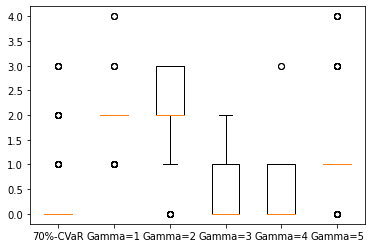

In [22]:
data=(tuple(pcvar),)
l=["70%-CVaR"]
for g in range(1,6):
  size=1000
  prob=[]
  for i in inst:
    ship_num=len(i[2])
    robust(ship_num,i[0],i[1],i[2],g,size)
    prob+=list(penalty_r)
    print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

In [8]:
OR

[[1, 2, 3, 4, 5],
 [2, 1, 3, 4, 5],
 [1, 2, 3, 4, 5],
 [2, 1, 3, 4, 5],
 [1, 2, 3, 4, 5],
 [1, 2, 4, 3, 5],
 [1, 2, 4, 3, 5],
 [1, 2, 3, 5, 4],
 [2, 1, 4, 3, 5],
 [1, 2, 3, 5, 4],
 [1, 2, 3, 4, 5],
 [2, 1, 4, 3, 5],
 [1, 2, 3, 5, 4],
 [1, 2, 3, 4, 5],
 [2, 4, 1, 3, 5],
 [1, 3, 5, 4, 2],
 [2, 1, 4, 3, 5],
 [1, 3, 2, 5, 4],
 [1, 2, 3, 4, 5],
 [1, 5, 2, 3, 4],
 [1, 2, 3, 4, 5],
 [2, 1, 4, 3, 5],
 [1, 2, 3, 4, 5],
 [1, 2, 3, 4, 5],
 [1, 3, 2, 4, 5],
 [2, 1, 4, 3, 5],
 [1, 2, 4, 3, 5],
 [5, 1, 3, 2, 4],
 [1, 2, 3, 4, 5],
 [1, 2, 3, 4, 5],
 [2, 1, 4, 3, 5],
 [2, 1, 4, 3, 5],
 [1, 2, 4, 3, 5],
 [2, 4, 1, 5, 3],
 [1, 3, 2, 4, 5],
 [1, 2, 3, 4, 5],
 [1, 3, 2, 5, 4],
 [1, 2, 4, 3, 5],
 [1, 3, 2, 4, 5],
 [1, 3, 2, 4, 5],
 [5, 1, 3, 2, 4],
 [1, 3, 2, 5, 4],
 [1, 3, 2, 4, 5],
 [2, 1, 4, 3, 5],
 [2, 1, 5, 4, 3],
 [1, 2, 3, 4, 5],
 [1, 3, 5, 2, 4],
 [1, 3, 2, 4, 5],
 [1, 3, 2, 4, 5],
 [1, 2, 3, 4, 5],
 [2, 1, 3, 4, 5],
 [1, 2, 3, 4, 5],
 [1, 2, 4, 3, 5],
 [1, 2, 5, 3, 4],
 [2, 1, 4, 3, 5],
 [1, 5, 3,

## インスタンス

In [20]:
stack_num=6
height=6
n=[4,3,3,3,2,3,3,2,2,3]
ship_num=len(n)
size=1000
IPS6(ship_num,stack_num,height,n,size,0.7)

C:\Users\daiki\AppData\Local\Temp\ipykernel_11288\3933875652.py:29: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = np.random.multivariate_normal(mean, cov, size=size)


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 901076 rows, 31361 columns and 10833320 nonzeros
Model fingerprint: 0x98a68f84
Variable types: 31001 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 0 rows and 0 columns (presolve time = 11s) ...
Presolve removed 0 rows and 0 columns (presolve time = 15s) ...
Presolve removed 0 rows and 0 columns (presolve time = 21s) ...
Presolve removed 0 rows and 0 columns (presolve time = 26s) ...
Presolve removed 0 rows and 0 columns (presolve time = 31s) ...
Presolve removed 0 rows and 0 columns (presolve time = 36s) ...
Presolve removed 0 rows and 0 columns (presolve time = 40s) ...
Presolve removed 0 rows and 0 columns (presolve time = 47s) ...
Presolve removed 0 rows and 0 columns

C:\Users\daiki\AppData\Local\Temp\ipykernel_11288\3933875652.py:119: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size)


In [11]:
data=(tuple(penalty[round(0.98*size):]),)
l=["70%-CVaR"]
for g in range(1,5):
  robust(ship_num,stack_num,height,n,g,size)
  data+=(tuple(penalty_r),)
  l.append("Gamma="+str(g))
# print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)

NameError: name 'stack_num' is not defined

## RS^PM

In [22]:
S=[i+1 for i in range(stack_num)]
H=[i+1 for i in range(height)]
P=[i+1 for i in range(ship_num)]
T=[i+1 for i in range(20)]

S,H,P,T

([1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [23]:
m=Model("RSPM")

x,y={},{}
for s in S:
  for h in H:
    for p in P:
      for t in T:
        x[s,h,p,t]=m.addVar(vtype="B")

for s in S:
  for k in S:
    if s!=k:
      for t in T:
        if t!=len(T):
          y[s,k,t]=m.addVar(vtype="C",lb=0)

for p in P:
   for t in T:
      m.addConstr(quicksum(x[s,h,p,t] for s in S for h in H)==n[p-1])

for t in range(1,len(T)):
   m.addConstr(quicksum(y[s,k,t] for s in S for k in S if k!=s)<=1)

for t in range(1,len(T)-1):
  m.addConstr(quicksum(y[s,k,t+1] for s in S for k in S if s!=k)<=quicksum(y[s,k,t] for s in S for k in S if k!=s))

for s in S:
  for t in range(2,len(T)+1):
    m.addConstr(quicksum(x[s,1,p,t] for p in P)<=1)

for s in S:
  for h in range(1,len(H)):
    for t in range(2,len(T)):
      m.addConstr(quicksum(x[s,h+1,p,t] for p in P)<=quicksum(x[s,h,p,t] for p in P))

for s in S:
  for h in range(1,len(H)):
    for p in P:
      for t in range(1,len(T)):
        m.addConstr(x[s,h,p,t]+quicksum(x[s,h+1,k,t] for k in P)<=1+x[s,h,p,t+1])

for s in S:
  for h in H:
    for p in P:
      for t in range(1,len(T)):
        m.addConstr(x[s,h,p,t]<=x[s,h,p,t+1]+quicksum(y[s,k,t] for k in S if k!=s))
        m.addConstr(x[s,h,p,t+1]<=x[s,h,p,t]+quicksum(y[k,s,t] for k in S if k!=s))

# for s in S:
#   for h in range(1,len(H)):
#     for p in P:
#       m.addConstr(quicksum(x[s,h+1,k,len(T)] for k in range(p,len(P)+1))<=quicksum(x[s,h,k,len(T)] for k in range(p,len(P)+1)))

for k in S:
   for t in range(1,len(T)-1):
    m.addConstr(quicksum(y[s,k,t] for s in S if s!=k)+quicksum(y[s,k,t+1] for s in S if s!=k)<=1)

In [26]:
result

array([[ 0,  1,  0,  2,  0,  3],
       [ 0,  1,  0,  2,  0,  3],
       [ 0,  1,  4,  2,  0,  8],
       [ 1,  6,  4,  7,  3, 10],
       [ 5,  6,  4,  7,  9, 10],
       [ 5,  6,  8,  7,  9, 10]])

In [31]:
for i in range(stack_num):
  for j in range(height):
    if result[height-j-1][i]!=0:
      # print(i+1,j+1,result[height-j-1][i])
      m.addConstr(x[i+1,j+1,result[height-j-1][i],len(T)]==1)

In [37]:
init=[[1,1,10],[1,2,9],[1,3,3],[1,4,1],[1,5,1],[2,1,9],[2,2,5],[2,3,7],[2,4,3],[2,5,1],[3,1,10],[3,2,8],[3,3,2],[3,4,3],[3,5,1],
[4,1,7],[4,2,6],[4,3,4],[4,4,5],[5,1,10],[5,2,6],[5,3,7],[5,4,2],[6,1,8],[6,2,6],[6,3,4],[6,4,4],[6,5,2]]
for i in init:
  m.addConstr(x[i[0],i[1],i[2],1]==1)

In [38]:
m.setObjective(quicksum(y[s,k,t] for s in S for k in S if k!=s for t in range(1,len(T))))
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20435 rows, 7770 columns and 186086 nonzeros
Model fingerprint: 0xeba8a74a
Variable types: 570 continuous, 7200 integer (7200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 3820 rows and 1563 columns
Presolve time: 1.38s
Presolved: 16615 rows, 6207 columns, 155277 nonzeros
Variable types: 587 continuous, 5620 integer (5620 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    6544    6.0890779e-04   1.757875e+04   0.000000e+00      5s
   14421    4.5960318e+00   9.405971e+05   0.000000e+00     10s
   19816    5.7900101e+00   4.001097e+06   0.000000e+00     15s
   23670    5.9386285e+00   8.698596e+05   0.000000e+00     20s
   27099    6.0006488e+00   2.1608

In [82]:
print("the objective function", m.objVal)
#   print("VaR=",alpha.X)

the objective function 1.0


In [81]:
EPS=1.e-5
for (n,t) in v:
  if t!=1:
    if (v[n,t].X-v[n,t-1].X)>EPS:
      print("v[%2s,%2s]=%3s" %(n,t,v[n,t].X))

NameError: name 'v' is not defined

## 不確実性集合の作成

In [158]:
G=[]
U=[1,2,3,4]
tmp=U[0]
for i in range(len(U[0])-1):
  U[0][i],U[0][i+1]=U[0][i+1],U[0][i]
  U.append(U[0])
  U[0]=tmp
U

[[2, 3, 4, 1], [2, 3, 4, 1], [2, 3, 4, 1], [2, 3, 4, 1]]

In [133]:
def swap(U):
  # for i in range(len(U)-1):
  U[i],U[i+1]=U[i+1],U[i]
  return U

In [152]:
U=[[1,2,3,4]]
U.append([])
U[1]=[2]
U

[[1, 2, 3, 4], [2]]

In [146]:
U=[1,2,3,4]
swap0(U[0],U[1])

(2, 1)